# **Crimes in Washington, DC - Analysis**

### Packages

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)

### Read in API data (2015-2019)

Below is the crime incident data for 2015-2019 from OpenDataDC (https://opendata.dc.gov/). There is a seperate API for each year, so the code below reads in the data, converts it into dataframes and concatenates them.

In [2]:
url_crime_2015 = 'https://opendata.arcgis.com/datasets/35034fcb3b36499c84c94c069ab1a966_27.geojson'
df_crime_2015 = gpd.read_file(url_crime_2015)

In [3]:
url_crime_2016 = 'https://opendata.arcgis.com/datasets/bda20763840448b58f8383bae800a843_26.geojson'
df_crime_2016 = gpd.read_file(url_crime_2016)

In [4]:
url_crime_2017 = 'https://opendata.arcgis.com/datasets/6af5cb8dc38e4bcbac8168b27ee104aa_38.geojson'
df_crime_2017 = gpd.read_file(url_crime_2017)

In [5]:
url_crime_2018 = 'https://opendata.arcgis.com/datasets/38ba41dd74354563bce28a359b59324e_0.geojson'
df_crime_2018 = gpd.read_file(url_crime_2018)

In [6]:
url_crime_2019 = 'https://opendata.arcgis.com/datasets/f08294e5286141c293e9202fcd3e8b57_1.geojson'
df_crime_2019 = gpd.read_file(url_crime_2019)

In [7]:
df_crime = pd.concat([df_crime_2015, df_crime_2016, df_crime_2017, df_crime_2018, df_crime_2019])

### Clean API Data

In [8]:
# remove unnecessary columns
df_crime = df_crime[['CCN', 'START_DATE', 'END_DATE', 'REPORT_DAT', 'SHIFT', 'WARD', 'BLOCK_GROUP', 'CENSUS_TRACT', 
                     'BLOCK', 'OFFENSE', 'METHOD', 'LATITUDE', 'LONGITUDE']]

In [9]:
# create columns for year, month, and day of the week
df_crime['year'] = pd.DatetimeIndex(df_crime['START_DATE']).year
df_crime['month'] = pd.DatetimeIndex(df_crime['START_DATE']).month
df_crime['dayofweek'] = pd.DatetimeIndex(df_crime['START_DATE']).dayofweek
df_crime['dayofweek'] = df_crime['dayofweek'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 
                                                   5:'Saturday', 6:'Sunday'})
# remove null values from START_DATE
df_crime = df_crime[pd.notnull(df_crime['START_DATE'])]

In [10]:
# create seperate column for START_DATE as 'date'
df_crime['date'] = df_crime['START_DATE']

# change format of date columns to datetime and set START_DATE to index
df_crime.date = pd.to_datetime(df_crime.date, format='%Y/%m/%d %H:%M:%S')
df_crime.index = pd.to_datetime(df_crime.START_DATE, format='%Y/%m/%d %H:%M:%S')
df_crime.END_DATE = pd.to_datetime(df_crime.END_DATE, format='%Y/%m/%d %H:%M:%S')
df_crime.REPORT_DAT = pd.to_datetime(df_crime.REPORT_DAT, format='%Y/%m/%d %H:%M:%S')

In [11]:
# get names of indexes for columns with report dates before 2015
indexNames = df_crime[df_crime['year'] < 2015].index
# delete these row indexes from df_crime to remove crimes committed before 2015
df_crime.drop(indexNames, inplace=True)

In [12]:
# create column for time of day where:
    # morning   =  05:00 - 09:59
    # afternoon =  10:00 - 17:59
    # evening   =  18:00 - 21:59
    # night     =  22:00 - 4:59 
hours = df_crime['date'].dt.hour
bins = [-1, 4, 9, 17, 21]
labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']
df_crime['time_of_day'] = np.array(labels)[np.array(bins).searchsorted(hours)-1]

In [13]:
# create new column for violent crimes and property crimes where:
#   violent = ASSAULT W/DANGEROUS WEAPON, HOMICIDE, ROBBERY, SEX ABUSE
#   property = MOTOR VEHICLE THEFT, THEFT F/AUTO, THEFT/OTHER, BURGLARY, ARSON

# define function to map values for new column
def set_value(row_number, assigned_value):
    return assigned_value[row_number]
# create dictionary of offenses
offense_dictionary = {'ASSAULT W/DANGEROUS WEAPON': 'violent', 'HOMICIDE': 'violent', 'ROBBERY': 'violent',
                      'SEX ABUSE': 'violent', 'THEFT/OTHER': 'property', 'THEFT F/AUTO': 'property',
                      'MOTOR VEHICLE THEFT': 'property', 'BURGLARY': 'property', 'ARSON': 'property'}
# add new column to dataframe for offense grouping
df_crime['OFFENSE_GROUP'] = df_crime['OFFENSE'].apply(set_value, args=(offense_dictionary, ))

In [28]:
# view dataframe head
df_crime.head()

,CCN,START_DATE,END_DATE,REPORT_DAT,SHIFT,WARD,BLOCK_GROUP,CENSUS_TRACT,BLOCK,OFFENSE,METHOD,LATITUDE,LONGITUDE,year,month,dayofweek,date,time_of_day,OFFENSE_GROUP
START_DATE,,,,,,,,,,,,,,,,,,,
2015-08-30 02:14:49,11535619,2015-08-30T02:14:49,2015-08-30 02:20:15,2015-08-30 02:57:29,MIDNIGHT,7,007804 3,007804,4800 - 4899 BLOCK OF CENTRAL AVENUE NE,ROBBERY,GUN,38.890393,-76.933411,2015.0,8.0,Sunday,2015-08-30 02:14:49,Night,violent
2015-01-15 09:30:00,15007302,2015-01-15T09:30:00,2015-01-15 20:35:00,2015-01-15 20:39:00,EVENING,6,008301 2,008301,417 - 499 BLOCK OF 6TH STREET NE,BURGLARY,OTHERS,38.895781,-76.998455,2015.0,1.0,Thursday,2015-01-15 09:30:00,Morning,property
2015-01-15 19:16:00,15007303,2015-01-15T19:16:00,2015-01-15 19:18:00,2015-01-15 19:21:00,EVENING,8,007407 2,007407,1400 - 1407 BLOCK OF HOWARD ROAD SE,ASSAULT W/DANGEROUS WEAPON,GUN,38.860027,-76.989872,2015.0,1.0,Thursday,2015-01-15 19:16:00,Evening,violent
2015-01-15 20:40:00,15007309,2015-01-15T20:40:00,2015-01-15 20:41:00,2015-01-15 21:20:00,EVENING,8,007502 2,007502,2400 - 2501 BLOCK OF 25TH STREET SE,ASSAULT W/DANGEROUS WEAPON,OTHERS,38.858050,-76.969987,2015.0,1.0,Thursday,2015-01-15 20:40:00,Evening,violent
2015-01-15 19:30:00,15007312,2015-01-15T19:30:00,2015-01-15 20:30:00,2015-01-15 21:14:00,EVENING,5,002302 1,002302,100 - 379 BLOCK OF MICHIGAN AVENUE NE,THEFT/OTHER,OTHERS,38.928797,-77.004498,2015.0,1.0,Thursday,2015-01-15 19:30:00,Evening,property


### Quick EDA

Quick overview of total number of crimes by:
- Year
- Day of the week
- Type of weapon used

In [15]:
crime_year = pd.DataFrame(df_crime.year.value_counts())
crime_year = pd.DataFrame(crime_year.iloc[:,0])
crime_year.columns = ['Total Crime per Year']
crime_year

,Total Crime per Year
2015.0,37337
2016.0,37175
2018.0,33787
2017.0,33037
2019.0,29465


In [16]:
crime_week = pd.DataFrame(df_crime.dayofweek.value_counts())
crime_week.columns = ['Total Crime per Day of Week']
crime_week

,Total Crime per Day of Week
Friday,26456
Saturday,25080
Monday,24507
Wednesday,23933
Tuesday,23784
Thursday,23695
Sunday,23346


In [156]:
# type of weapon used in attack

method_df = pd.DataFrame(df_crime.METHOD.value_counts())
method_df.columns = ['Total Crime by Weapon Used']
method_df

,Total Crime by Weapon Used
OTHERS,157515
GUN,8914
KNIFE,4372


### Visualizations

Various time series and categorical visualizations for:
- Time series: Number of crimes by month, week, day
- Time series: Number of crimes by type (violent crime vs property crime)
- Time series: Number of crimes by Offense Type per year (2015-2019)
- Time series: Number of crimes by Offense Type per month (2015, 2016, 2017, 2018, 2019)
- Total crimes by year, month, day of the week
- Total crimes by offense type
- Total crimes by weapon used
- Total crimes by ward and time of way

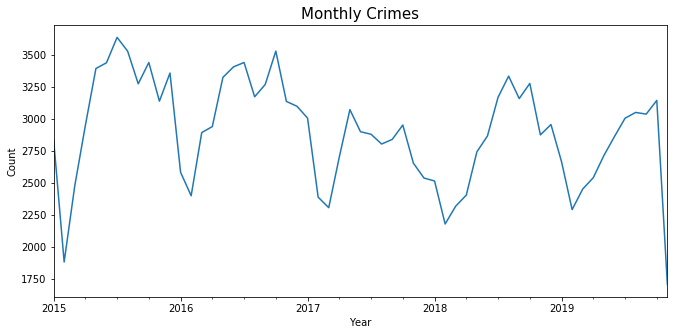

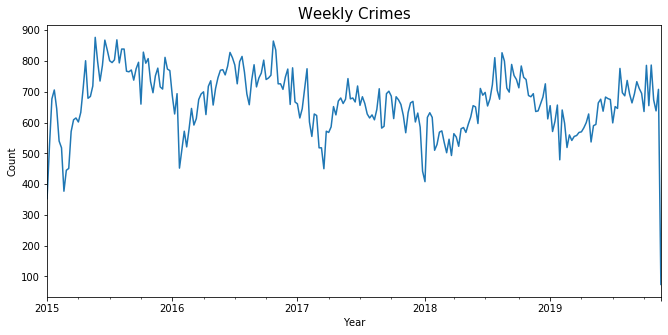

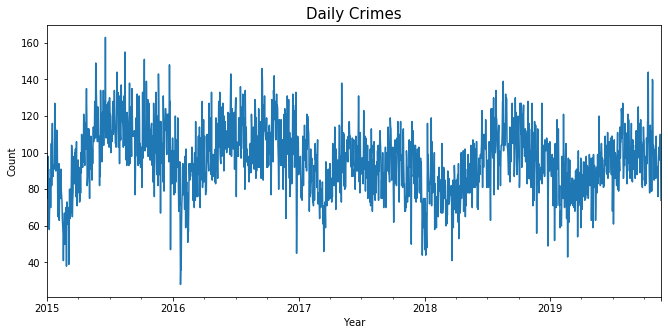

In [134]:
# number of crimes per month
plt.figure(figsize=(11, 5))
df_crime.resample('m').size().plot()
plt.title('Monthly Crimes', fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

# number of crimes per week
plt.figure(figsize=(11, 5))
df_crime.resample('W').size().plot()
plt.title('Weekly Crimes', fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

# number of crimes per day
plt.figure(figsize=(11, 5))
df_crime.resample('d').size().plot()
plt.title('Daily Crimes', fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.show()

In [119]:
# create dataframe for each year
df_crime_2015 = df_crime[df_crime['year'] == 2015]
df_crime_2016 = df_crime[df_crime['year'] == 2016]
df_crime_2017 = df_crime[df_crime['year'] == 2017]
df_crime_2018 = df_crime[df_crime['year'] == 2018]
df_crime_2019 = df_crime[df_crime['year'] == 2019]

# group dataframes to prep for plotting
group_type = df_crime.groupby(['year', 'OFFENSE_GROUP'])['date'].count().unstack()
group_all = df_crime.groupby(['year', 'OFFENSE'])['date'].count().unstack()
group_2015 = df_crime_2015.groupby(['month', 'OFFENSE'])['date'].count().unstack()
group_2016 = df_crime_2016.groupby(['month', 'OFFENSE'])['date'].count().unstack()
group_2017 = df_crime_2017.groupby(['month', 'OFFENSE'])['date'].count().unstack()
group_2018 = df_crime_2018.groupby(['month', 'OFFENSE'])['date'].count().unstack()
group_2019 = df_crime_2019.groupby(['month', 'OFFENSE'])['date'].count().unstack()

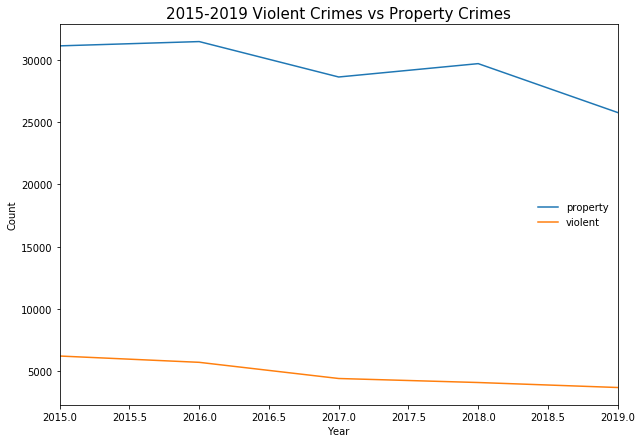

In [133]:
plt.rcParams['figure.figsize'] = [10, 7]

# violent crimes vs property crimes
group_type.plot()
plt.title('2015-2019 Violent Crimes vs Property Crimes', fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend(loc='right', frameon=False)
plt.show()

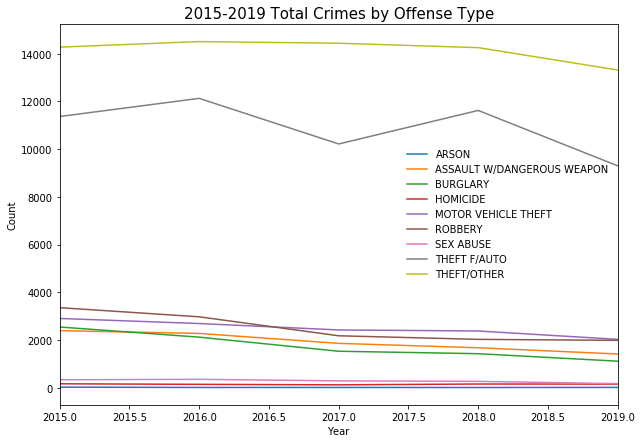

In [132]:
# total crimes by offense type
group_all.plot()
plt.title('2015-2019 Total Crimes by Offense Type', fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend(loc='right', frameon=False)
plt.show()

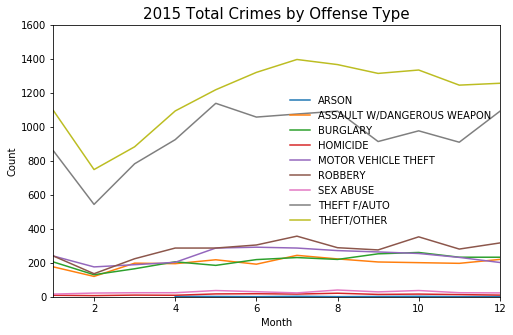

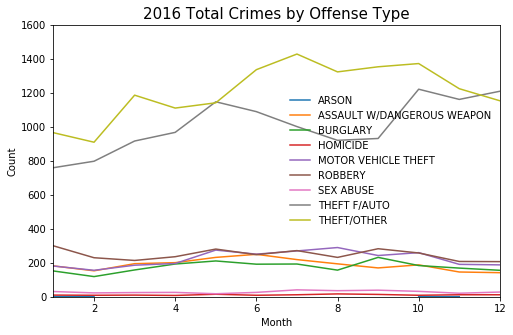

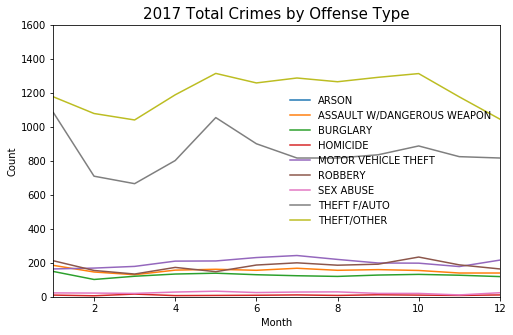

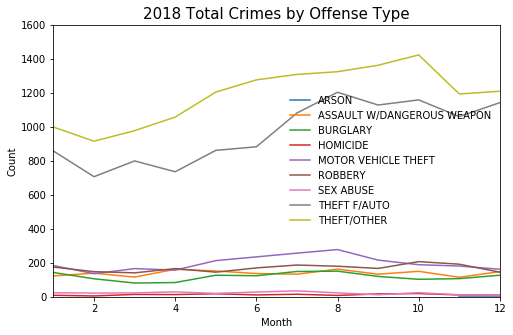

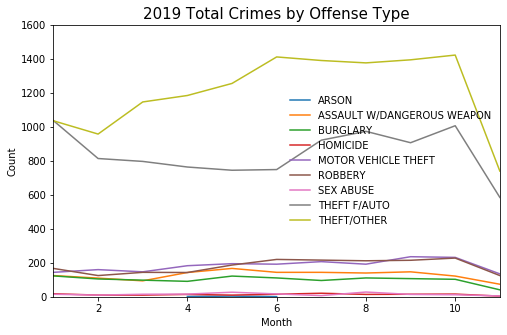

In [136]:
plt.rcParams['figure.figsize'] = [8, 5]

# 2015 total crimes by offense type
axes = group_2015.plot()
plt.title('2015 Total Crimes by Offense Type', fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend(loc='right', frameon=False)
axes.set_ylim([0, 1600])
plt.show()

# 2016 total crimes by offense type
axes = group_2016.plot()
plt.title('2016 Total Crimes by Offense Type', fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend(loc='right', frameon=False)
axes.set_ylim([0, 1600])
plt.show()

# 2017 total crimes by offense type
axes = group_2017.plot()
plt.title('2017 Total Crimes by Offense Type', fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend(loc='right', frameon=False)
axes.set_ylim([0, 1600])
plt.show()

# 2018 total crimes by offense type
axes = group_2018.plot()
plt.title('2018 Total Crimes by Offense Type', fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend(loc='right', frameon=False)
axes.set_ylim([0, 1600])
plt.show()

# 2019 total crimes by offense type
axes = group_2019.plot()
plt.title('2019 Total Crimes by Offense Type', fontsize=15)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.legend(loc='right', frameon=False)
axes.set_ylim([0, 1600])
plt.show()

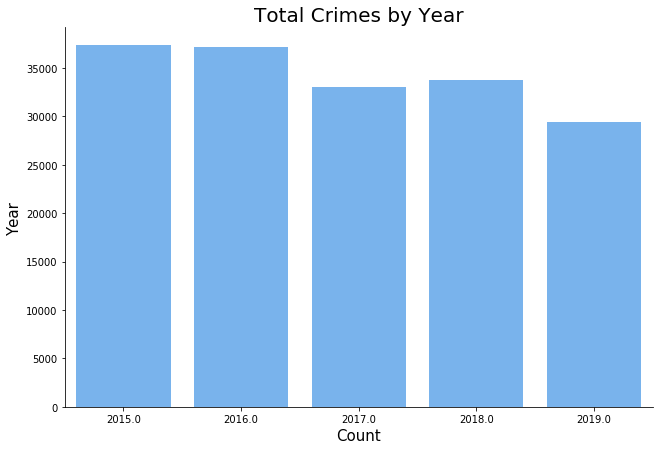

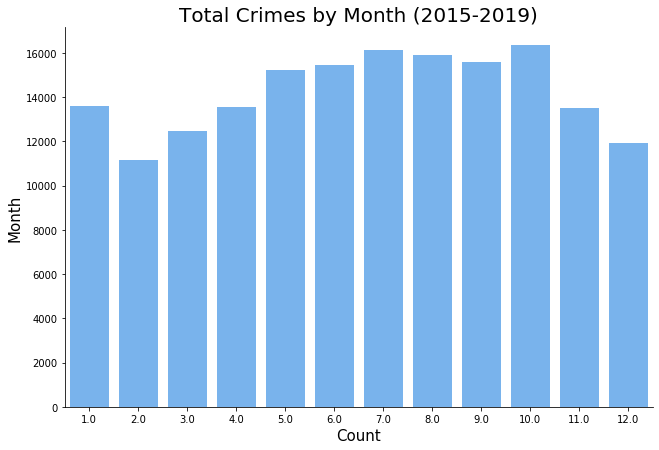

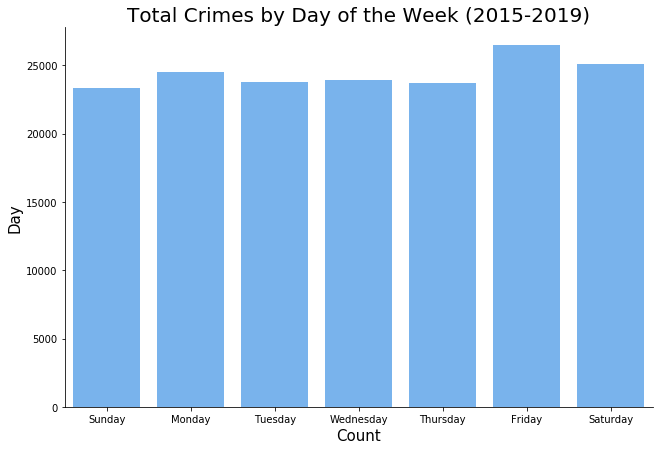

In [186]:
color = ['#66b3ff']

# bar plot for total crimes by year
plot = sns.catplot(x='year', kind='count', height=6, aspect=1.5, 
                   data=df_crime, palette=sns.color_palette(color))
plt.title('Total Crimes by Year', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Year', fontsize=15)
plt.show()

# bar plot for total crimes by month
sns.catplot(x='month', kind='count', height=6, aspect=1.5,
            data=df_crime, palette=sns.color_palette(color))
plt.title('Total Crimes by Month (2015-2019)', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Month', fontsize=15)
plt.show()

# bar plot for total crimes by day of the week
sns.catplot(x='dayofweek', kind='count', height=6, aspect=1.5,
            data=df_crime, palette=sns.color_palette(color), 
            order=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.title('Total Crimes by Day of the Week (2015-2019)', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Day', fontsize=15)
plt.show()

Text(-150.559375, 0.5, 'Offense Type')

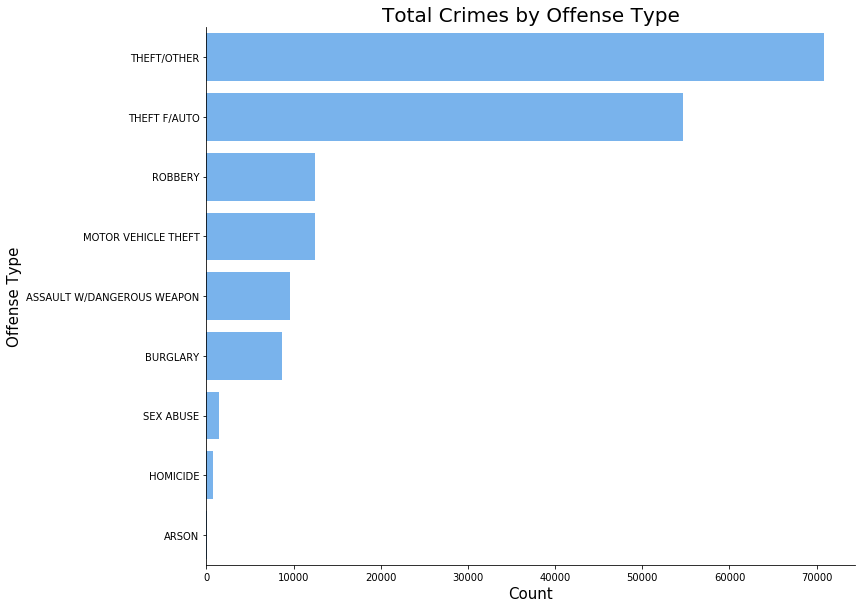

In [187]:
# horizontal bar plot for count of offense type
sns.catplot(y='OFFENSE', kind='count', height=8, aspect=1.5, order=df_crime.OFFENSE.value_counts().index, 
            data=df_crime, palette=sns.color_palette(color))

plt.title('Total Crimes by Offense Type', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Offense Type', fontsize=15)

/Users/henrytappa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  """


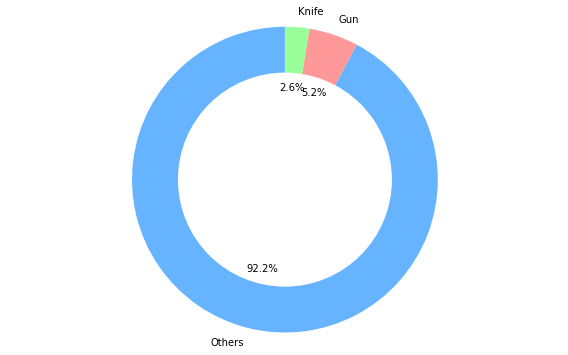

In [183]:
# pie chart for total crimes by weapon used
labels = ['Others', 'Gun', 'Knife']
colors = ['#66b3ff', '#ff9999','#99ff99']
fig1, ax1 = plt.subplots()
ax1.pie(method_df, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.show()

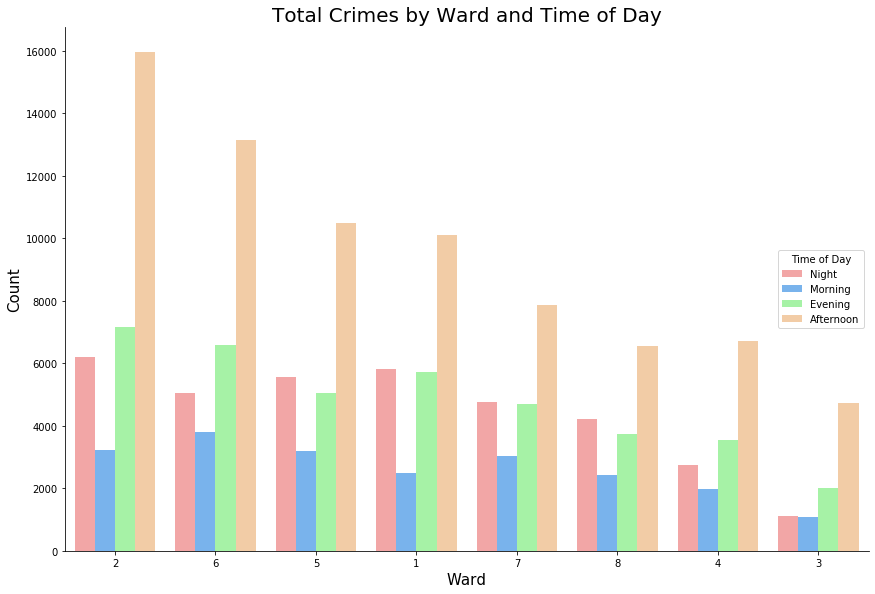

In [185]:
# bar plot for count of total crimes by ward and time of day
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

sns.catplot(x='WARD', hue='time_of_day', kind='count', height=8, aspect=1.5, order=df_crime.WARD.value_counts().index, 
            data=df_crime, legend=False, palette=sns.color_palette(colors))

plt.title('Total Crimes by Ward and Time of Day', fontsize=20)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel('Ward', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(title='Time of Day', loc='right')